In [35]:
import torch
import matplotlib.pyplot as plt
from utils import *
from ControlledLayer import ControlledNetwork
from tqdm.notebook import tqdm

In [37]:


def control_neuron_rate(
    input_rate,
    target_rate,
    control_target_rate,
    timesteps,
    C_precision=0.01,
):
    input_rate = torch.tensor(input_rate)
    
    with torch.no_grad():
        out, cont = net.evolve_to_convergence(input_rate, target_rate, control_target_rate)

    return out, cont

In [38]:
from utils import control_neuron_rate as old_cnr

input = [0.3, 0.09, 1.0]
net = ControlledNetwork((3, 1), mode="rate", leak=1.)
layer = net.layers[0]
w_0 = np.array([-5., 5., -5.]) 
layer.ff.weight.data = torch.tensor(w_0).float()
layer.fb.weight.data = torch.tensor([1.]).float()

print("=== OLD FUNCTION ===")
output, input_C = old_cnr(np.dot(input, w_0), 0, -1, timesteps=2)
print(output, '\n', input_C)
print(len(output))


print("=== NEW FUNCTION ===")
output, input_C = control_neuron_rate(input, 0, -1, timesteps=2)
print(output, '\n', input_C)
print(len(output))



=== OLD FUNCTION ===
[0.0012032200458068308] 
 []
1
=== NEW FUNCTION ===
[[0.00235232]] 
 []
1


In [39]:
v_th = 1
target_rates = [-1, 2]
learn_rate = 0.01
regularizer_rate = 0.0  # 0.00005#
C_precision = 0.01
data_noise = 0.1
timesteps = 2
initial_steps_plot = 5
neuron_noise = 0.

plot_path = "./plots/"

total_points = 6000
train_points = 5000
w_0 = np.array([-5., 5., -5.]) 
X, y = learnAssociationTask(total_points, data_noise=data_noise)
dynamic_plot_idxs = [1, 501, 2001, 9001]


In [40]:
net = ControlledNetwork((3, 1), mode="rate", leak=1.)
layer = net.layers[0]
w_0 = np.array([-5., 5., -5.]) 
layer.ff.weight.data = torch.tensor(w_0).float()
layer.fb.weight.data = torch.tensor([1.]).float()

w_evol = []
control_evol = []
FF_output_evol = []
time_to_targ_evol = []
DW_DH_list = []
DW_STDP_list = []
list_output_dynamics = []
list_controller_dynamics = []

count_1 = 0
next_dyn_plot_idx = 0
X = torch.tensor(X).float()


# loop over datapoints
for idx in tqdm(range(len(y))):
    target_rate = y[idx]
    x = X[idx]
    control_target_rate = target_rates[target_rate]

    # FORWARD, with controller controlling
    output, input_C = control_neuron_rate(x, target_rate, control_target_rate, timesteps=timesteps)
    R = len(output) - 1  # number of timesteps the controller had to act?

    if R > 0:  # avoids learning if the feedback is already good
        presynaptic_rates = torch.sigmoid(x).unsqueeze(0).expand((R, -1)).numpy()
        Dw_DH = update_weights_rates(output[:-1], presynaptic_rates)
        Dw_STDP = update_weights_poisson(output[:-1], presynaptic_rates)
        layer.ff.weight.data += torch.tensor(Dw_STDP).float() - regularizer_rate * layer.ff.weight.data

        DW_DH_list.append(Dw_DH)
        DW_STDP_list.append(Dw_STDP)

    count_1 += y[idx]
    if count_1 == dynamic_plot_idxs[next_dyn_plot_idx]:
        list_output_dynamics.append(output[1:])
        list_controller_dynamics.append(input_C)
        next_dyn_plot_idx = (next_dyn_plot_idx + 1) % len(dynamic_plot_idxs)

    w_evol.append(layer.ff.weight.data.clone().numpy())
    FF_output_evol.append(output[0])
    time_to_targ_evol.append(len(input_C))

    if len(input_C) > 1:
        control_evol.append(input_C[-1])
    else:
        control_evol.append(0)



  0%|          | 0/6000 [00:00<?, ?it/s]

/tmp/ipykernel_372613/32089593.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_rate = torch.tensor(input_rate)


CPU times: user 24.1 s, sys: 35.4 ms, total: 24.2 s
Wall time: 24.1 s


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


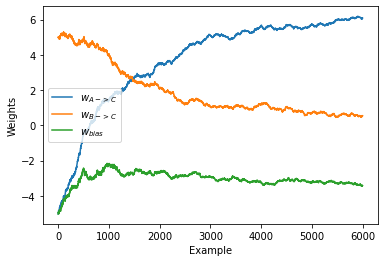

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


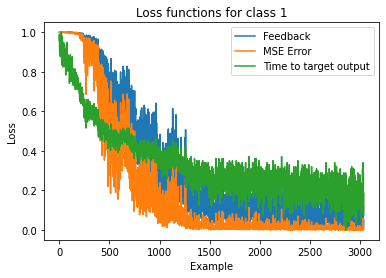

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


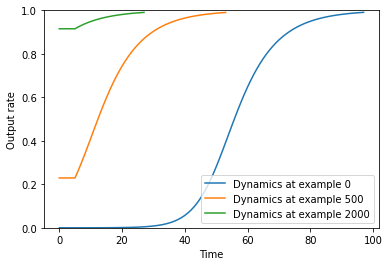

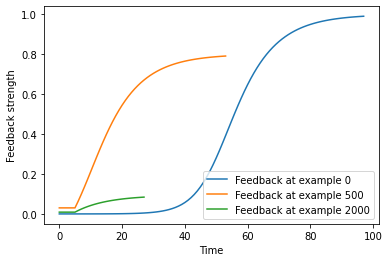

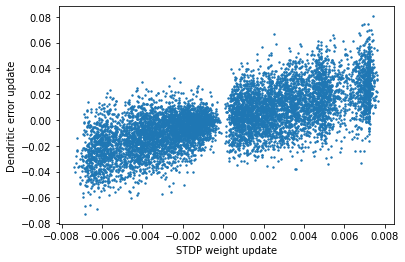

In [41]:
plt.show()

# ax = plt.axes()
# ax.set_facecolor("white")
plt.plot(w_evol)
plt.legend(["$w_{A->C}$", "$w_{B->C}$", "$w_{bias}$"])
plt.xlabel("Example")
plt.ylabel("Weights")
plt.savefig(
    plot_path + "WeightEvolution.eps", bbox_inches="tight", format="eps"
)

plt.show()

# Benni: Fig 2, panel 1. Normalized to have the maximum at 1
max_FF = max(FF_output_evol)
max_C = max(control_evol)
max_T = max(time_to_targ_evol)
control_evol_norm = [c / max_C for (c, s) in zip(control_evol, y) if s == 1]
FF_output_evol_norm = [
    (1 - f) ** 2 for (f, s) in zip(FF_output_evol, y) if s == 1
]
time_to_output_evol_norm = [
    t / max_T for (t, s) in zip(time_to_targ_evol, y) if s == 1
]
plt.plot(control_evol_norm, label="Feedback")
plt.plot(FF_output_evol_norm, label="MSE Error")
plt.plot(time_to_output_evol_norm, label="Time to target output")
plt.xlabel("Example")
plt.ylabel("Loss")
plt.title("Loss functions for class 1")
plt.legend()
plt.savefig(
    plot_path + "OptimizationFunctions.eps", bbox_inches="tight", format="eps"
)
plt.show()

# Benni: Fig 4 A
for i in range(len(list_output_dynamics)):
    str_dynamics = "Dynamics at example " + str(dynamic_plot_idxs[i] - 1)
    dynamics = list_output_dynamics[i]
    # init_dynamics, v = runNeuron_rate([0]*initial_steps_plot)
    init_dynamics = [
        dynamics[0] + n * neuron_noise / 2
        for n in np.random.randn(initial_steps_plot)
    ]
    list_to_plot = np.vstack((init_dynamics, dynamics))
    plt.plot(list_to_plot, label=str_dynamics)
# plt.plot(output, label="Dynamics at last example")
plt.ylim([0.0, 1])
plt.xlabel("Time")
plt.ylabel("Output rate")
plt.legend()
plt.savefig(
    plot_path + "TemporalDynamics.eps", bbox_inches="tight", format="eps"
)
plt.show()

for i in range(len(list_output_dynamics)):
    str_dynamics = "Feedback at example " + str(dynamic_plot_idxs[i] - 1)
    init_ctr = list_controller_dynamics[i]
    init_control = [
        init_ctr[0] + n * neuron_noise / 2
        for n in np.random.randn(initial_steps_plot)
    ]
    list_to_plot = np.vstack((init_control, list_controller_dynamics[i]))
    plt.plot(list_to_plot, label=str_dynamics)

# plt.plot(input_C, label="Feedback at last example")
plt.xlabel("Time")
plt.ylabel("Feedback strength")
plt.legend()
plt.show()
plt.savefig(
    plot_path + "TemporalFeedback.eps", bbox_inches="tight", format="eps"
)
# STDP vs dendritic error update
L_errors = int(
    len(DW_DH_list) / 2
)  # when plotting errors after learning we get noise
plt.scatter(DW_DH_list[:L_errors], DW_STDP_list[:L_errors], s=2)
plt.xlabel("STDP weight update")
plt.ylabel("Dendritic error update")
plt.savefig(plot_path + "STDP_vs_DH.eps", bbox_inches="tight", format="eps")

plt.show()


In [30]:
np.vstack((init_dynamics, dynamics))

array([[1.60999807e-05],
       [1.60999807e-05],
       [1.60999807e-05],
       [1.60999807e-05],
       [1.60999807e-05],
       [1.60999807e-05],
       [1.96644487e-05],
       [2.40180580e-05],
       [2.93355042e-05],
       [3.58301222e-05],
       [4.37625313e-05],
       [5.34508908e-05],
       [6.52839735e-05],
       [7.97363246e-05],
       [9.73876813e-05],
       [1.18945871e-04],
       [1.45275291e-04],
       [1.77431357e-04],
       [2.16702683e-04],
       [2.64662958e-04],
       [3.23232438e-04],
       [3.94756207e-04],
       [4.82095056e-04],
       [5.88740921e-04],
       [7.18954136e-04],
       [8.77929444e-04],
       [1.07200292e-03],
       [1.30889681e-03],
       [1.59801822e-03],
       [1.95082219e-03],
       [2.38124700e-03],
       [2.90623889e-03],
       [3.54637858e-03],
       [4.32663085e-03],
       [5.27722947e-03],
       [6.43472699e-03],
       [7.84320384e-03],
       [9.55567975e-03],
       [1.16356965e-02],
       [1.41591011e-02],
